# Weitere Vorverarbeitungs-Schritte

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor

plt.style.use('ggplot')

print("Setup complete")

Setup complete


In [3]:
def add_lag_features(dataframe, columns):
    """
    Fügt einem DataFrame Verzögerungs-Features (Lags) für die angegebenen Spalten hinzu. 
    Für jede Spalte in 'columns' wird ein Verzögerungs-Feature hinzugefügt.
    Jedes Verzögerungs-Feature ist eine Verschiebung der Originalspalte um einen Schritt.

    :param dataframe: Pandas DataFrame, zu dem die Verzögerungs-Features hinzugefügt werden sollen.
    :param columns: Liste der Spaltennamen, für die Verzögerungs-Features erstellt werden sollen.
    :return: DataFrame mit den zusätzlichen Verzögerungs-Features.
    """
    lagged_df = dataframe.copy()
    for column in columns:
        lagged_df[f'{column}_lag'] = lagged_df[column].shift(1)
    return lagged_df


def print_metrics(actual, predicted):
    """
    Berechnet MAE, RMSE und MAPE zwischen den tatsächlichen und vorhergesagten Werten.
    :param actual: Array der tatsächlichen Werte
    :param predicted: Array der vorhergesagten Werte
    """
    actual, predicted = np.array(actual), np.array(predicted)

    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = mean_absolute_percentage_error(actual, predicted) * 100

    print(f"MAE: {round(mae, 2)}, RMSE: {round(rmse, 2)}, MAPE: {round(mape, 2)} %")

In [4]:
df = pd.read_csv("../input/2024-01-05-2/austin10_hourly.csv")
df = df[df.dataid == 661].drop('dataid', axis=1)
df.set_index('timestamp', inplace=True)

df.describe()

,use,construction_year,n_residents,n_rooms,total_area,outdoor_temp,app_outdoor_temp,humidity,day,wday,...,oven,n_oven,range,n_range,refrigerator,n_refrigerator,utilityroom,n_utilityroom,venthood,n_venthood
count,8984.000000,8984.0,8984.0,8984.0,8984.00,8982.000000,8982.000000,8982.000000,8984.000000,8984.000000,...,0.0,8984.0,0.0,8984.0,8792.000000,8984.000000,0.0,8984.0,0.0,8984.0
mean,1.537178,2007.0,2.0,6.0,154.59,20.462463,21.003727,0.695354,16.091607,2.991541,...,NaN,0.0,NaN,0.0,0.059896,0.978629,NaN,0.0,NaN,0.0
std,1.216942,0.0,0.0,0.0,0.00,9.292182,10.452528,0.212019,8.786340,2.007649,...,NaN,0.0,NaN,0.0,0.038375,0.144627,NaN,0.0,NaN,0.0
min,0.143000,2007.0,2.0,6.0,154.59,-8.660000,-13.580000,0.130000,1.000000,0.000000,...,NaN,0.0,NaN,0.0,0.001000,0.000000,NaN,0.0,NaN,0.0
25%,0.594750,2007.0,2.0,6.0,154.59,13.690000,13.690000,0.530000,9.000000,1.000000,...,NaN,0.0,NaN,0.0,0.041250,1.000000,NaN,0.0,NaN,0.0
50%,1.038250,2007.0,2.0,6.0,154.59,22.130000,22.590000,0.730000,16.000000,3.000000,...,NaN,0.0,NaN,0.0,0.056500,1.000000,NaN,0.0,NaN,0.0
75%,2.179563,2007.0,2.0,6.0,154.59,27.080000,28.860000,0.880000,24.000000,5.000000,...,NaN,0.0,NaN,0.0,0.068250,1.000000,NaN,0.0,NaN,0.0
max,7.054000,2007.0,2.0,6.0,154.59,41.990000,42.340000,1.000000,31.000000,6.000000,...,NaN,0.0,NaN,0.0,0.494500,1.000000,NaN,0.0,NaN,0.0


In [5]:
# Spalten entfernen, in denen jeder Wert identisch ist
cols_to_drop = [col for col in df.columns if df[col].nunique() <= 1]
df.drop(cols_to_drop, axis=1, inplace=True)

zukunftsbezogene_features = ['outdoor_temp', 'app_outdoor_temp', 'humidity', 'air', 'bathroom', 'car', 'clotheswasher',
                             'dishwasher', 'drye', 'furnace', 'kitchenapp', 'microwave', 'refrigerator']

# Verzögerungs-Features hinzufügen und zukunftsbezogene Features entfernen --> Um Data Leakage zu verhindern
df = add_lag_features(df, zukunftsbezogene_features)
df.drop(zukunftsbezogene_features, axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8984 entries, 2018-01-01 07:00:00 to 2019-01-01 05:00:00
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   use                   8984 non-null   float64
 1   day                   8984 non-null   int64  
 2   wday                  8984 non-null   int64  
 3   month                 8984 non-null   int64  
 4   hour                  8984 non-null   int64  
 5   n_bathroom            8984 non-null   int64  
 6   n_clotheswasher       8984 non-null   int64  
 7   n_disposal            8984 non-null   int64  
 8   n_furnace             8984 non-null   int64  
 9   n_kitchenapp          8984 non-null   int64  
 10  n_microwave           8984 non-null   int64  
 11  n_refrigerator        8984 non-null   int64  
 12  outdoor_temp_lag      8981 non-null   float64
 13  app_outdoor_temp_lag  8981 non-null   float64
 14  humidity_lag          8981 non-null   float6

In [6]:
# Prozentsatz der fehlenden Werte für jede Spalte
missing_share = df.isnull().mean() * 100

# Maximale Länge der Spaltennamen
max_column_name_len = max(len(column) for column in df.columns)

for column_name, percent_val in missing_share.items():
    if percent_val > 0:
        print(f"{column_name.ljust(max_column_name_len)}\t{percent_val:.2f}%")

outdoor_temp_lag    	0.03%
app_outdoor_temp_lag	0.03%
humidity_lag        	0.03%
air_lag             	0.01%
bathroom_lag        	2.23%
car_lag             	0.01%
clotheswasher_lag   	2.23%
dishwasher_lag      	2.15%
drye_lag            	0.01%
furnace_lag         	2.15%
kitchenapp_lag      	2.23%
microwave_lag       	2.15%
refrigerator_lag    	2.15%


Da pro Feature weniger als 3 Prozent der Daten fehlen, wird ein einfacher "SimpleImputer" verwendet, der fehlende Einträge mit dem Median imputiert.

In [7]:
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

train_y = train_data.pop('use')
train_X = train_data
test_y = test_data.pop('use')
test_X = test_data

# Erstellung eines Random Forest-Modells

In [8]:
missing_cols = missing_share[(missing_share > 0)].index.tolist()

simple_imputer = SimpleImputer(strategy='median')

preprocessor = ColumnTransformer(transformers=[('simple', simple_imputer, missing_cols)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor(random_state=1))])

param_grid = {
    'regressor__n_estimators': [100, 200, 300],  # Anzahl der Bäume im Wald
    'regressor__max_depth': [None, 10, 20, 30],  # Maximale Tiefe der Bäume
    'regressor__min_samples_split': [2, 5, 10],  # Minimale Anzahl von Samples, die benötigt werden, um einen internen Knoten zu teilen
    'regressor__min_samples_leaf': [1, 2, 4],  # Minimale Anzahl von Samples, die ein Blattknoten haben muss
    'regressor__max_features': [None, 'sqrt', 'log2'],  # Anzahl der Features, die bei der Suche nach dem besten Split berücksichtigt werden sollen
    'regressor__bootstrap': [True, False]  # Ob Bootstrap-Proben beim Aufbau der Bäume verwendet werden sollen
}

# Cross Validation schon mit drin?
cv = RandomizedSearchCV(pipeline, param_grid, n_iter=10, cv=3, verbose=2, random_state=1, n_jobs=-1)

cv.fit(train_X, train_y)

best_model = cv.best_estimator_

predictions = best_model.predict(test_X)

print_metrics(test_y, predictions)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
MAE: 0.45, RMSE: 0.71, MAPE: 47.03 %


### "Für das systematische Tuning können Sie GridSearchCV oder RandomizedSearchCV aus Scikit-Learn verwenden."

In [9]:
df_comp = pd.DataFrame(test_y)
df_comp.reset_index(inplace=True)
df_comp['timestamp'] = pd.to_datetime(df_comp.timestamp)
df_comp.rename(columns={'use': 'actual'}, inplace=True)
df_comp['predicted_rf'] = predictions
df_comp.sample(5)

,timestamp,actual,predicted_rf
1331,2018-12-12 20:00:00,0.30150,0.694801
623,2018-11-13 08:00:00,0.64800,1.003500
696,2018-11-16 09:00:00,1.60650,1.045788
1278,2018-12-10 15:00:00,0.55400,0.774131
869,2018-11-23 14:00:00,0.56675,0.887681


# Erstellung eines XGBoost-Modells

In [10]:
pipeline2 = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', XGBRegressor(random_state=1))])

param_grid2 = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 6, 10],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__subsample': [0.7, 0.9, 1],
    'regressor__colsample_bytree': [0.7, 0.9, 1],
    'regressor__min_child_weight': [1, 2, 4]
}

cv2 = RandomizedSearchCV(pipeline2, param_grid2, n_iter=10, cv=3, verbose=2, random_state=1, n_jobs=-1)

cv2.fit(train_X, train_y)

best_model2 = cv2.best_estimator_

predictions2 = best_model2.predict(test_X)

print_metrics(test_y, predictions2)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
MAE: 0.49, RMSE: 0.73, MAPE: 52.66 %


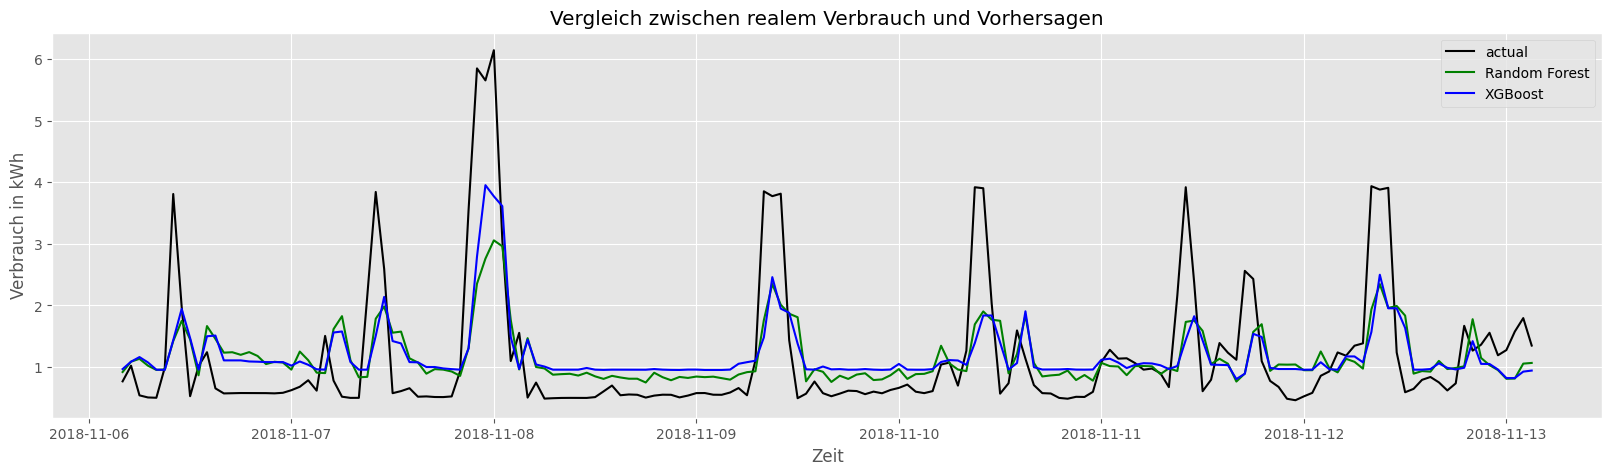

In [12]:
df_comp['predicted_xgb'] = predictions2

datapoints_week = 24 * 7
last_start_idx = len(df_comp) - datapoints_week - 1
start_idx = random.randint(0, last_start_idx)
end_idx = start_idx + 24 * 7
df_plot = df_comp[start_idx:end_idx]

plt.figure(figsize=(20, 5))
plt.plot(df_plot.timestamp, df_plot.actual, color='black', label='actual')
plt.plot(df_plot.timestamp, df_plot.predicted_rf, color='green', label='Random Forest')
plt.plot(df_plot.timestamp, df_plot.predicted_xgb, color='blue', label='XGBoost')
plt.title('Vergleich zwischen realem Verbrauch und Vorhersagen')
plt.xlabel('Zeit')
plt.ylabel('Verbrauch in kWh')
plt.legend()
plt.show()

# Permutation Importance
https://www.kaggle.com/code/dansbecker/permutation-importance

In [13]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(cv, random_state=1).fit(test_X, test_y)
eli5.show_weights(perm, feature_names = test_X.columns.tolist())

Weight,Feature
0.3479 ± 0.0246,car_lag
0.0397 ± 0.0074,drye_lag
0.0371 ± 0.0057,clotheswasher_lag
0.0153 ± 0.0044,app_outdoor_temp_lag
0.0143 ± 0.0039,outdoor_temp_lag
0.0139 ± 0.0044,air_lag
0.0097 ± 0.0038,furnace_lag
0.0083 ± 0.0032,kitchenapp_lag
0.0082 ± 0.0045,bathroom_lag
0.0066 ± 0.0079,humidity_lag
